# Exercise 06
## 1 Bias and variance of ridge regression

## 2 Denoising of a CT image

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import lsqr
from scipy.ndimage.filters import gaussian_filter
%matplotlib notebook

from scipy import sparse

In [38]:
def construct_X(M, alphas, Np = None, tau=0):
    D = M*M
    # define sensor size
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        if Np % 2 == 0: Np += 1
    # number of angles
    No = len(alphas)
    
    # flattened output coordinates
    j = np.mgrid[0:D].astype(np.int32)
    # coordinate matrix for the output pixels
    M2 = (M-1) / 2
    grid = np.mgrid[-M2:M-M2,-M2:M-M2].swapaxes(1,2).reshape(2,D)
    
    # collect indices and corresponding values for all iterations
    i_indices = []
    j_indices = []
    weights = []
    
    for k, alpha in enumerate(alphas):
        # convert angle and prepare projection vector
        alph_rad = np.radians(alpha)
        proj_vec = np.array([np.cos(alph_rad), -np.sin(alph_rad)])
        # project coordinates
        proj = np.dot(proj_vec, grid) + Np // 2
        # compute sensor indices and weights below the projected points
        i = np.floor(proj)
        w = (i+1) - proj
        
        # make sure rays falling outside the sensor are not counted
        clip = np.logical_and(0 <= i, i < Np-1)
        
        i_indices.append((i + k*Np)[clip])
        j_indices.append(j[clip])
        weights.append(w[clip])
        # compute sensor indices and weights above the projected points
        w = proj - i
        i_indices.append((i+1 + k*Np)[clip])
        j_indices.append(j[clip])
        weights.append(w[clip])
        
    # construct matrix X
    i = np.concatenate(i_indices).astype(np.int32)
    j = np.concatenate(j_indices).astype(np.int32)
    w = np.concatenate(weights)
    X = sparse.coo_matrix((w, (i,j)), shape = (No*Np, D), dtype = np.float32)
    
    if tau == 0:
        return X
    else:
        bot = np.sqrt(tau) * sparse.identity(D, dtype = np.float32, format = 'coo')
        return sparse.vstack([X, bot])

In [39]:
M = 195
Np = 275
alpha_count = 64
y = np.load('hs_tomography/y_195.npy')
alphas = np.load('hs_tomography/alphas_195.npy')

# select 64 angles
index = []
for i in range(alpha_count):
    index.append(int(np.ceil(len(alphas) * i / alpha_count)))
a_sub = alphas[index]

# construct y
y_sub = []
for i in index:
    y_sub.extend(y[i*Np : (i+1)*Np])

<IPython.core.display.Javascript object>


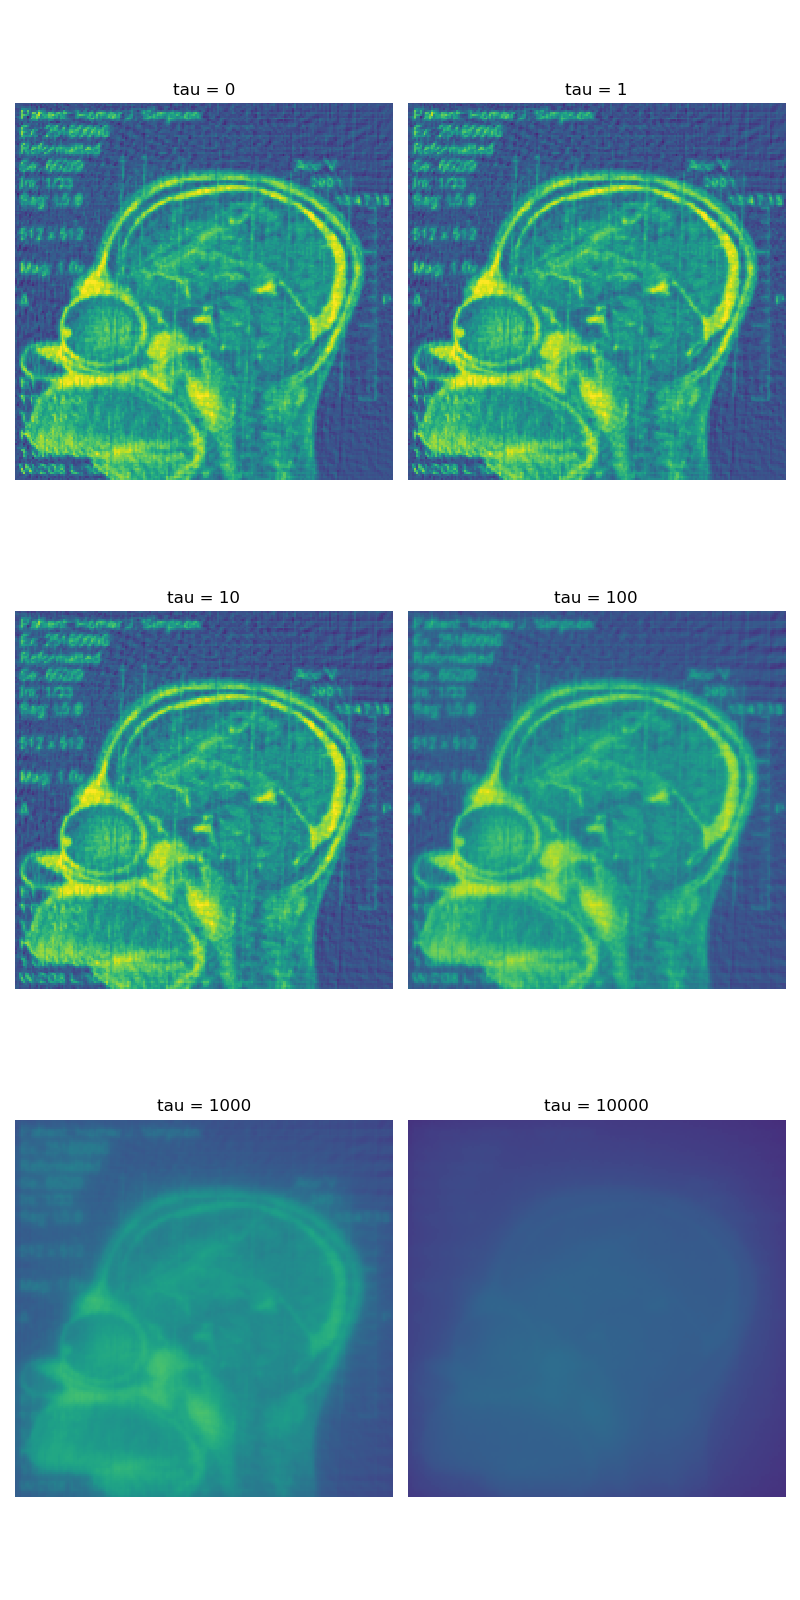

In [40]:
# RIDGE REGRESSION #

y_sub_ext = y_sub[:]
fig, axes = plt.subplots(3, 2, figsize = (8,16))

taus = [0, 1, 10, 100, 1000, 10000]
for n, tau in enumerate(taus):
    X = construct_X(M, a_sub, Np, tau).tocsc()
    
    # extend y with D zeros
    while len(y_sub_ext) < X.shape[0]:
        y_sub_ext.append(0.0)
    
    beta = lsqr(X, np.array(y_sub_ext), atol = 1e-5, btol = 1e-5)[0].reshape(M,M)
    
    axes.flat[n].imshow(beta, vmin = 0, vmax = 255, interpolation = 'nearest')
    axes.flat[n].set_title('tau = {}'.format(tau))
    axes.flat[n].axis('off')

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


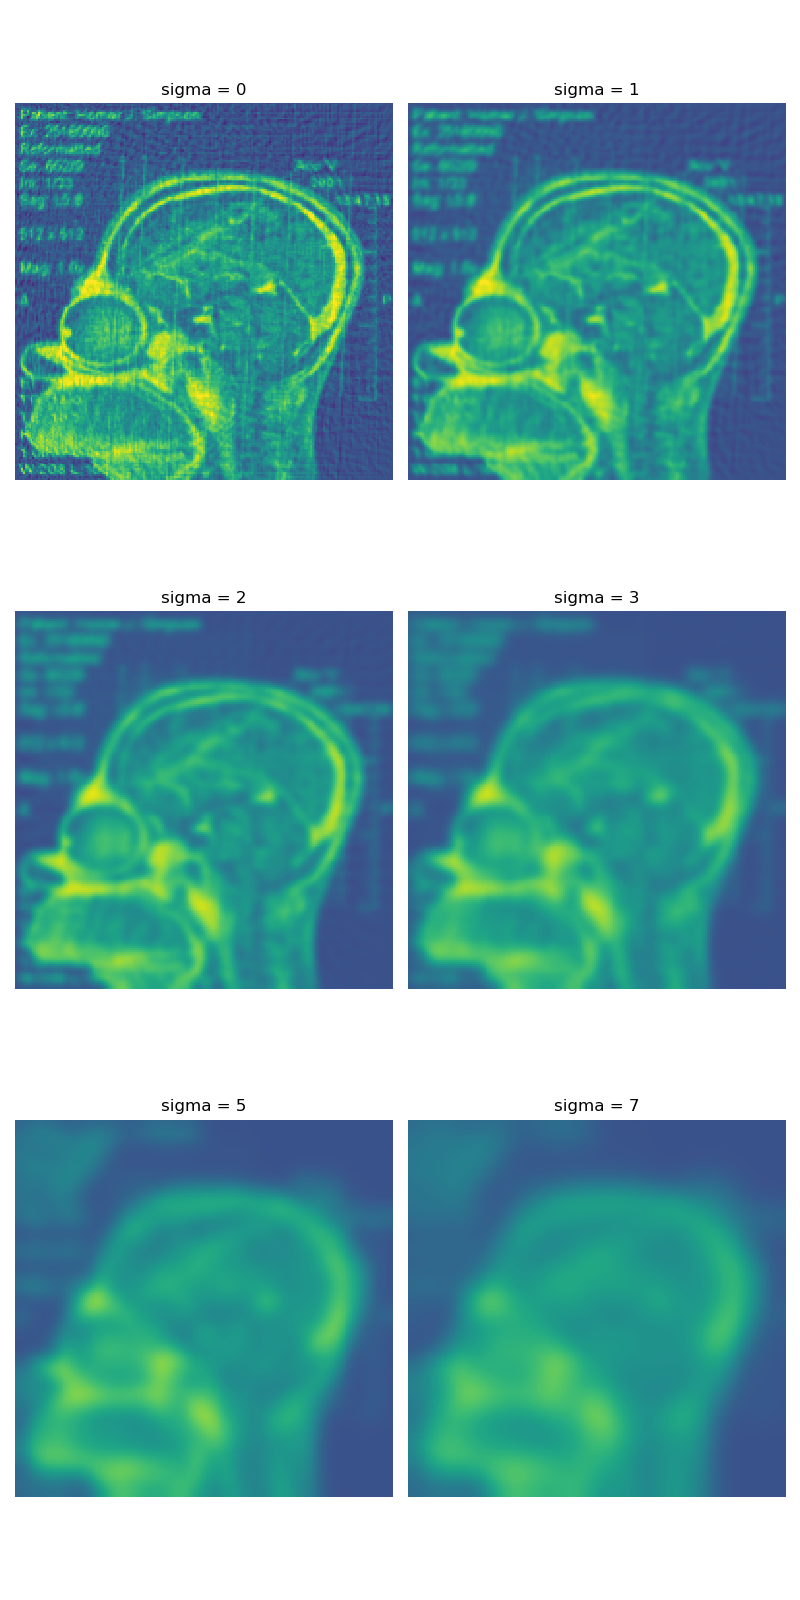

In [45]:
# GAUSSIAN FILTER #

fig, axes = plt.subplots(3, 2, figsize = (8,16))

sigmas = [0, 1, 2, 3, 5, 7]
for n, sigma in enumerate(sigmas):
    X = construct_X(M, a_sub, Np, 0).tocsc()
    beta = lsqr(X, np.array(y_sub), atol = 1e-5, btol = 1e-5)[0].reshape(M,M)
    
    beta = gaussian_filter(beta, sigma)
    
    axes.flat[n].imshow(beta, vmin = 0, vmax = 255, interpolation = 'nearest')
    axes.flat[n].set_title('sigma = {}'.format(sigma))
    axes.flat[n].axis('off')

fig.tight_layout()
plt.show()

With ridge regression tau=10 is the largest value at which all features are still visible while noise is slightly reduced. at tau=100 most relevant features are still visible but some finer details like the letters become indescernable. for larger tau values the contrast decreases significantly so that more subtle features fade.

With Gaussian filtering the sharpness of the image degrades significantly more while the contrast is largely unaffected. with sigma=1 parts of the text are already unlegible. At sigma > 2 most of the smaller features are not unrecognizable.

Overall ridge regression seems to provide a clearer image at similar levels of noise reduction.

## 3 Automatic feature selection for regression
### 3.1 Implement Orthogonal Matching Pursuit

In [1]:
from numpy.linalg import lstsq

In [2]:
def omp_regression(X, y, T):
    x_dim = X.shape[1]
    A = []
    B = [i for i in range(x_dim)]
    beta = np.zeros((x_dim, T))
    r = y
    for t in range(T):
        # 1
        max_correlation = np.array([np.abs(X[:,j].T @ r) for j in B])
        j_max = np.argmax(max_correlation)
        j = B[j_max]

        # 2
        B.remove(j)
        A.append(j)

        # 3
        active_X = X[:, A]

        # 4
        beta_hat_t = lstsq(active_X, y)[0]

        # 5
        r = active_X @ beta_hat_t
        beta[A, t] = beta_hat_t

    return beta

### 3.2 Classifcation with sparse LDA 

In [35]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

digits = load_digits()
data = digits["data"]
target = digits["target"]
target_names = digits["target_names"]

In [31]:
def filter_data(X, Y, y_contained):
    contained_indices = []
    for y_c in y_contained:
        contained_indices.extend(np.where(Y == y_c)[0])
    contained_indices = np.array(contained_indices)
    return X[contained_indices,:], Y[contained_indices]


def replace_target(Y):
    Y[Y==1] = 1
    Y[Y==7] = -1
    return Y

def lda_data_preparation(X, Y, test_size = 0.4):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=0)
    X_train_std, X_train_mean = np.std(X_train, axis=0), np.mean(X_train, axis=0)
    X_train_centered = (X_train - X_train_mean) / X_train_std
    X_test_centered = (X_test - X_train_mean) / X_train_std

    X_train_centered = np.nan_to_num(X_train_centered)
    X_test_centered =np.nan_to_num(X_test_centered)

    return X_train, X_train_centered, X_test, X_test_centered, Y_train, Y_test

X, Y = filter_data(data, target, [1, 7])
Y = replace_target(Y)
print(f'Filtered data size: {len(Y)}')

X_train, X_train_centered, X_test, X_test_centered, Y_train, Y_test = lda_data_preparation(X, Y)


Filtered data size: 361


/tmp/ipykernel_13152/646606608.py:17: RuntimeWarning: invalid value encountered in true_divide
  X_train_centered = (X_train - X_train_mean) / X_train_std
/tmp/ipykernel_13152/646606608.py:18: RuntimeWarning: invalid value encountered in true_divide
  X_test_centered = (X_test - X_train_mean) / X_train_std


In [20]:
def predict(X, beta_hat):
    y_hat = X @ beta_hat
    greater = y_hat > 0
    smaller = y_hat < 0
    y_hat[greater] = 1
    y_hat[smaller] = -1
    return y_hat

def calc_error(Y, Y_hat):
    return np.sum(Y != Y_hat) / len(Y)


/tmp/ipykernel_13152/2332796179.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_hat_t = lstsq(active_X, y)[0]


[0.496551724137931, 0.05517241379310345, 0.041379310344827586, 0.041379310344827586, 0.05517241379310345, 0.041379310344827586, 0.05517241379310345, 0.034482758620689655, 0.034482758620689655, 0.034482758620689655, 0.034482758620689655, 0.027586206896551724, 0.006896551724137931, 0.006896551724137931, 0.020689655172413793, 0.020689655172413793, 0.0, 0.0, 0.0, 0.0]
[0.041379310344827586, 0.06896551724137931, 0.06896551724137931, 0.07586206896551724, 0.09655172413793103, 0.08275862068965517, 0.07586206896551724, 0.08275862068965517, 0.08275862068965517, 0.034482758620689655, 0.034482758620689655, 0.041379310344827586, 0.013793103448275862, 0.013793103448275862, 0.020689655172413793, 0.020689655172413793, 0.006896551724137931, 0.0, 0.0, 0.0]


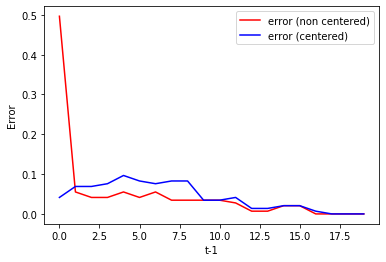

In [36]:
T = 20
solutions = omp_regression(X_train, Y_train, T)
solutions_std = omp_regression(X_train_centered, Y_train, T)
errors = []
errors_centered = []

for t in range(T):
    Y_hat = predict(X_test, solutions[:,t])
    error = calc_error(Y_test, Y_hat)
    errors.append(error)
    
    Y_hat_centered = predict(X_test_centered, solutions[:,t])
    error_centered = calc_error(Y_test, Y_hat_centered)
    errors_centered.append(error_centered)

plt.plot(errors,'r', label='error (non centered)')
plt.plot(errors_centered, 'b', label='error (centered)')
plt.ylabel('Error')
plt.xlabel('t-1')
plt.legend()
plt.show()

With t = 1 there is a big benefit of centering. For t > 1 there is no big difference between non standardized and standardized.

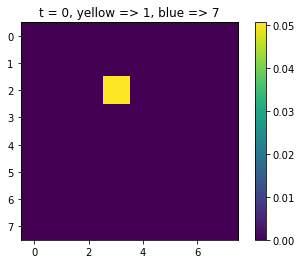

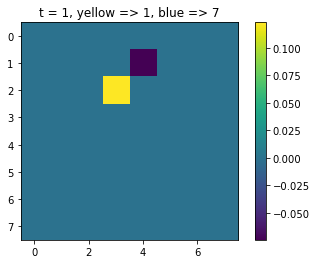

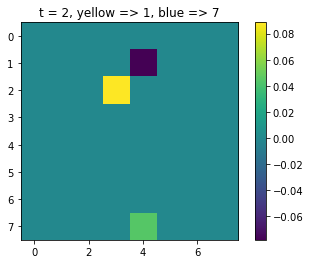

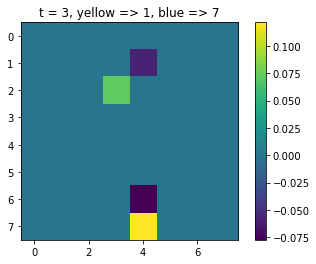

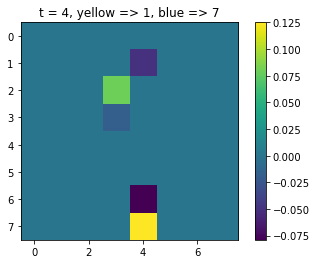

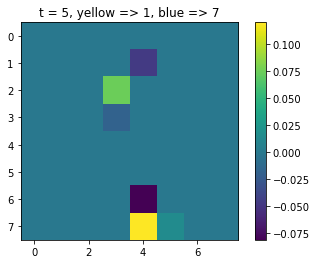

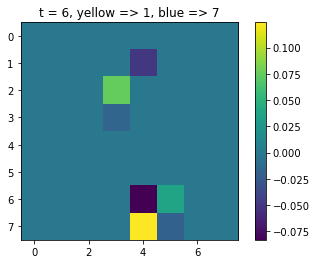

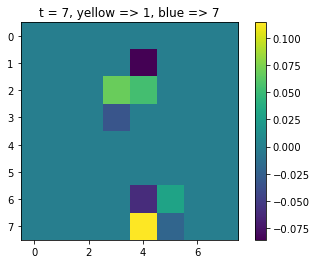

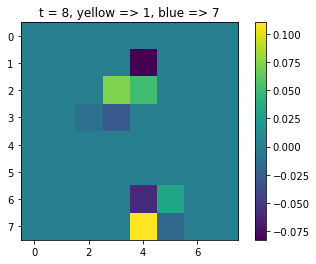

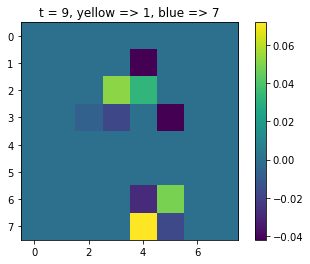

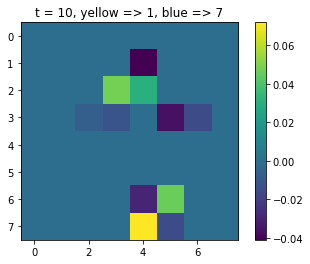

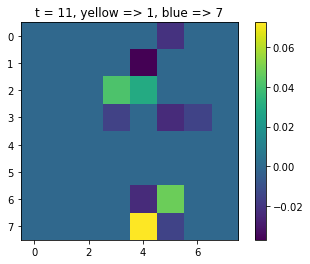

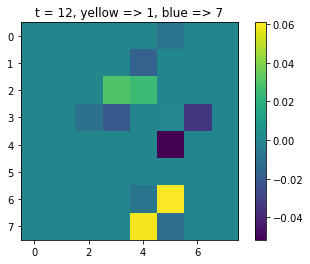

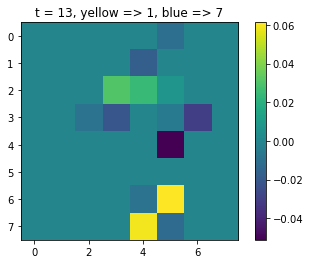

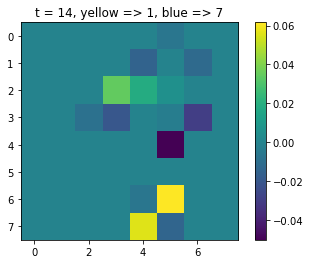

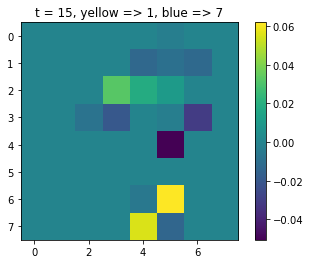

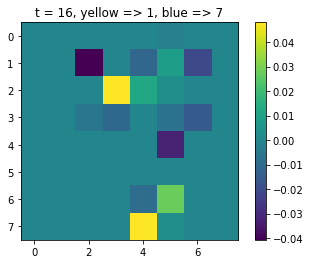

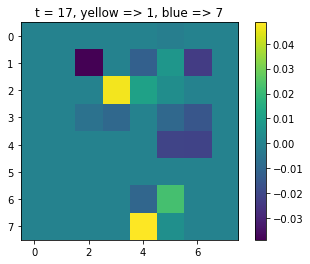

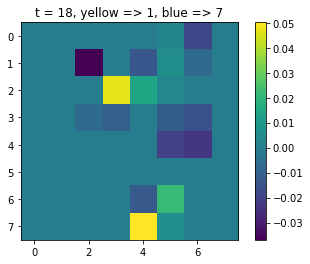

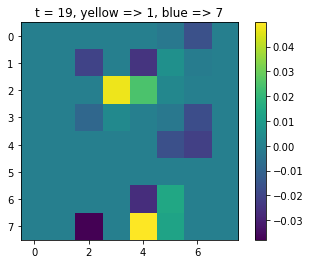

In [38]:
for t in range(T):
    plt.imshow(solutions[:,t].reshape((8,8)),interpolation='none')
    plt.title(f't = {t}, yellow => 1, blue => 7')
    plt.colorbar()
    plt.show()

### 3.3 One against the rest classifier

In [39]:
from sklearn.utils import shuffle

In [46]:
def filter_oar(X, Y, num):
    X, Y = shuffle(X, Y, random_state=0)

    one_indices = Y == num
    rest_indices = Y != num

    X_one = X[one_indices, :]
    X_rest = X[rest_indices[:len(one_indices)], :]

    Y_one = Y[one_indices]
    Y_rest = Y[rest_indices[:len(one_indices)]]
    
    X = np.concatenate((X_one, X_rest))
    Y = np.concatenate((Y_one, Y_rest))

    Y[Y != num] = -1
    Y[Y == num] = 1

    X, Y = shuffle(X, Y, random_state=0)
    return X, Y

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.4, random_state=0)

all_solutions = np.zeros((data.shape[1], 10))
T_one_against_rest = 20

for num in range(10):   
    X, Y = filter_oar(X_train, Y_train, num)
    solutions = omp_regression(X, Y, T)
    all_solutions[:,num] = solutions[:,T-1]

/tmp/ipykernel_13152/2332796179.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_hat_t = lstsq(active_X, y)[0]


In [48]:
predictions = np.zeros((X_test.shape[0], 10)) 

for digit in range(10):
    predictions[:,digit] = X_test @ all_solutions[:,digit]
    
y_hat = np.argmax(predictions, axis=1)    

error = calc_error(y_hat, Y_test)
print(f"Error rate: {error}")

Error rate: 0.17941585535465926
